# LAB 5: Text classification with Naive Bayes

## Part 1: Bernoulli NB Model

Objectives:

* Train and evaluate Naive Bayes text classifiers
* Cross-validation
* Hyperparameter search

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

### Load and preprocess data

In [24]:
df = pd.read_parquet(
    "s3://ling583/rcv1-politics.parquet", storage_options={"anon": True}
)

In [25]:
df.head()

,text,pol
0,Aoki Marine -96/97 parent forecast. Year to Ma...,False
1,PanEnergy Coro unit to redeem debentures. PanE...,False
2,Juel Verite - 6mth parent results. Six months ...,False
3,TEXAS TO MEXICO LIVESTOCK EXPORT WEEKLY - USDA...,False
4,Ex-UK air cargo rates steady to firm on high v...,False


We need to process this text.  We will tokenize it using spacy.

In [26]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)

Define a tokenizer and pull out the normalized version.  We are stripping out punctuation and numbers, so it will be alphabet only.

def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [28]:
df["tokens"] = df["text"].progress_apply(tokenize)

  0%|          | 0/60509 [00:00<?, ?it/s]

In [29]:
df.head()

,text,pol,tokens
0,Aoki Marine -96/97 parent forecast. Year to Ma...,False,"[aoki, marine, parent, forecast, year, to, mar..."
1,PanEnergy Coro unit to redeem debentures. PanE...,False,"[panenergy, coro, unit, to, redeem, debentures..."
2,Juel Verite - 6mth parent results. Six months ...,False,"[juel, verite, parent, results, six, months, t..."
3,TEXAS TO MEXICO LIVESTOCK EXPORT WEEKLY - USDA...,False,"[texas, to, mexico, livestock, export, weekly,..."
4,Ex-UK air cargo rates steady to firm on high v...,False,"[ex, uk, air, cargo, rates, steady, to, firm, ..."


Now we have our alphabetic tokens

Because most of the documents are not political, let us label the ones that are NOT about politics and evaluate the accuracy.

---

### Baseline dummy classifier

In [30]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

Set up five-fold cross-validation. We'll use the same training/test splits for all our experiments so the results will be easier to compare.

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432)

In [32]:
baseline = DummyClassifier()
cross_val_score(baseline, df["tokens"], df["pol"], cv=cv)

array([0.92951578, 0.92951578, 0.92951578, 0.92943315, 0.92950996])

We are getting about 93% accuracy.  Let's look at the predictions, and use them to compare against the correct answers.

In [33]:
predicted = cross_val_predict(baseline, df["tokens"], df["pol"], cv=cv)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     56243
        True       0.00      0.00      0.00      4266

    accuracy                           0.93     60509
   macro avg       0.46      0.50      0.48     60509
weighted avg       0.86      0.93      0.90     60509



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


If we do nothing, we have a 93% accuracy and 0 f1-score.  Let's try a binary naive bayes model.

----

### Bernoulli Naive Bayes

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline

Set up a pipeline (document term matrix): first convert tokenized text into feature vectors, then apply naive Bayes classifier

In [35]:
bnb = make_pipeline(CountVectorizer(analyzer=identity), BernoulliNB())

In [36]:
predicted = cross_val_predict(bnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.98      0.90      0.93     56243
        True       0.35      0.73      0.47      4266

    accuracy                           0.88     60509
   macro avg       0.66      0.81      0.70     60509
weighted avg       0.93      0.88      0.90     60509



Of the articles flagged for politics, 35% were really about politics.  Of the articles that are really about politics, 73% were flagged for politics.  Since f1-score has jumped from 0% to 47%, this is a little better, but at the sacrific of precision and recall.  The 35% is what we were looking for.  Not the best, but we will try to improve on this.

---

### Hyperparameter search

We will run experiments on different values of alpha to see how things change/improve.

In [37]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34037")
client

Client Scheduler: tcp://127.0.0.1:34037 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [38]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [39]:
# Use this to avoid all the warnings
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

In [40]:
bnb = make_pipeline(CountVectorizer(analyzer=identity), BernoulliNB())

Setup a search to try out a classfier for lots of different parameter values: alpha parameter and optimize f1 score

In [41]:
%%time

search = RandomizedSearchCV(
    bnb, {"bernoullinb__alpha": loguniform(1e-10, 10.0)}, n_iter=25, scoring="f1"
)
search.fit(df["tokens"], df["pol"])  #tokenized data as input, and politics as the labels

CPU times: user 20.4 s, sys: 2.66 s, total: 23.1 s
Wall time: 1min 52s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f05f7cde1e0>)),
                                             ('bernoullinb', BernoulliNB())]),
                   n_iter=25,
                   param_distributions={'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0549cc1490>},
                   scoring='f1')

In [42]:
search.best_params_

{'bernoullinb__alpha': 6.021629298309952e-10}

In [43]:
search.best_score_

0.5987700545873251

In [44]:
cv_results = pd.DataFrame(search.cv_results_)

In [46]:
cv_results.head()

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,param_bernoullinb__alpha
0,{'bernoullinb__alpha': 3.864766197836774e-08},7.796743,3.134331,2.493973,0.280724,0.596074,0.597950,0.587952,0.593992,0.004339,7,0.0
1,{'bernoullinb__alpha': 1.4834412205782722e-05},7.795609,3.139391,2.482212,0.274686,0.580855,0.573835,0.573529,0.576073,0.003383,13,0.000015
2,{'bernoullinb__alpha': 3.72737250839037e-05},7.826739,3.117609,2.715317,0.021152,0.572259,0.569801,0.565867,0.569309,0.002633,15,0.000037
3,{'bernoullinb__alpha': 1.2287457703723991e-05},7.811836,3.125555,2.610703,0.113459,0.581572,0.575284,0.574398,0.577085,0.003193,12,0.000012
4,{'bernoullinb__alpha': 1.1131314049196952e-08},7.819781,3.158142,2.771910,0.044851,0.599516,0.600477,0.591230,0.597074,0.004151,6,0.0


<AxesSubplot:xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

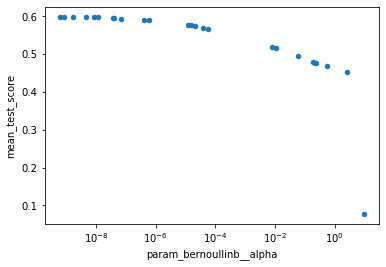

In [47]:
cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

We can see that as alpha gets bigger, the results get worse.  So for this, we want to aim for a very small alpha.

Now, we exclude words that are very frequent and infrequent.  We will experiment with the threshold levels.

In [48]:
%%time

search = RandomizedSearchCV(
    bnb,
    {
        "countvectorizer__min_df": randint(1, 5),  # we will try 1, 2, 3, 4
        "bernoullinb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 20.5 s, sys: 2.63 s, total: 23.1 s
Wall time: 2min 4s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f05f7cde1e0>)),
                                             ('bernoullinb', BernoulliNB())]),
                   n_iter=25,
                   param_distributions={'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f05b55d4a60>,
                                        'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f04ef306760>},
                   scoring='f1')

In [49]:
search.best_params_, search.best_score_

({'bernoullinb__alpha': 6.386373046701459e-09, 'countvectorizer__min_df': 1},
 0.5979303258817769)

In [50]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

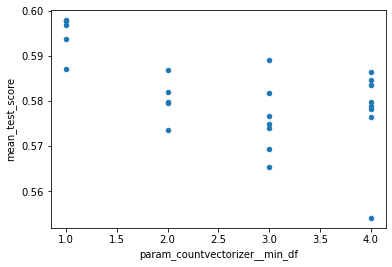

In [51]:
cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

Values of min_df vs score... as min_df gets higher the scores go down.

<AxesSubplot:xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

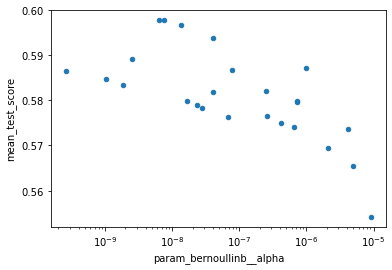

In [52]:
cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

Same... as alpha gets small, scores go down.

<AxesSubplot:xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

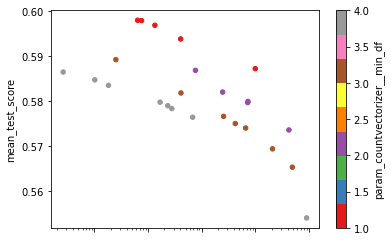

In [53]:
cv_results.plot(
    "param_bernoullinb__alpha",
    "mean_test_score",
    kind="scatter",
    logx=True,
    c="param_countvectorizer__min_df",
    colormap="Set1",
)

Given the graph, we want alpha as small as possible, and min_df = 1.  Let's find max_df which are the terms that are the most frequent.  We filter out the high frequency terms, but KEEP the low frequency terms.

In [54]:
%%time

search = RandomizedSearchCV(
    bnb,
    {
        "countvectorizer__min_df": [1],
        "countvectorizer__max_df": uniform(0.5, 0.5), # probably between 0.5 and 1, so we try 0.5 and evaluate. This will give random numbers between 0.5 and 1.
        "bernoullinb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 20.6 s, sys: 2.7 s, total: 23.3 s
Wall time: 3min 45s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f05f7cde1e0>)),
                                             ('bernoullinb', BernoulliNB())]),
                   n_iter=25,
                   param_distributions={'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f04ee576b50>,
                                        'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f04f7151dc0>,
                                        'countvectorizer__min_df': [1]},
                   scoring='f1')

In [55]:
search.best_params_, search.best_score_

({'bernoullinb__alpha': 2.1323261664554503e-09,
  'countvectorizer__max_df': 0.7829031597292002,
  'countvectorizer__min_df': 1},
 0.5992395759968318)

<AxesSubplot:xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

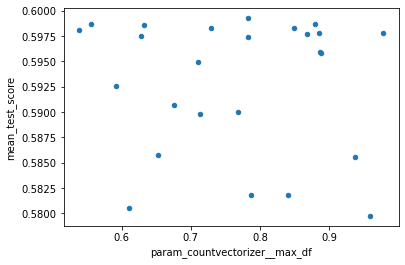

In [56]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

---

### Evaluate final model

In [57]:
bnb.set_params(
    bernoullinb__alpha=1e-10, countvectorizer__min_df=1, countvectorizer__max_df=0.78
)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x7f05f7cde1e0>,
                                 max_df=0.78)),
                ('bernoullinb', BernoulliNB(alpha=1e-10))])

In [58]:
predicted = cross_val_predict(bnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.98      0.96      0.97     56243
        True       0.54      0.68      0.60      4266

    accuracy                           0.94     60509
   macro avg       0.76      0.82      0.78     60509
weighted avg       0.94      0.94      0.94     60509

